<a href="https://colab.research.google.com/github/kalc1/CIT-99-Machine-Learning/blob/main/DimensionalityReductionKNN_KevinAlcocer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import of Libraries

In [ ]:
import json

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier



from yellowbrick.classifier.rocauc import roc_auc

!pip install scikit_optimize # Needed to work with skopt
from skopt import BayesSearchCV

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 942.2 kB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Initial Study of the Dataset

In [ ]:
with open("/content/drive/MyDrive/FCC/Machine Learning/Week 9 CIT 99/text","r") as fp:
  text = json.load(fp)

with open("/content/drive/MyDrive/FCC/Machine Learning/Week 9 CIT 99/labels","r") as fp:
  labels = json.load(fp)

In [ ]:
len(labels)

4000

In [ ]:
labels[3000] # [0...999] -> 1000 values -> 1000 documents -> Astrophysics
             # [1000...1999] -> 1000 values -> 1000 documents -> Computer Science
             # [2000...2999] -> 1000 values -> 1000 documents -> Math
             # [3000...3999] -> 1000 values -> 1000 documents -> Physics


'physics'

In [ ]:
text[0] # This is the first document

"b'There is now ample evidence that dust is already present in abundance at high z. However, given the faintness of distant galaxies in the optical and the NIR, datasets are still limited and how the dust affects the emerging radiation of galaxies at very high redshift is not yet fully understood. Using the ALPINE survey, our objective is to quantify the dust attenuation properties in galaxies at z=4.4-5.5, and in particular the shape of their attenuation curve. Using the CIGALE code, we model the stellar populations and their interaction with the dust in order to measure some of the physical properties of a subsample of 23 main-sequence ALPINE galaxies. We find that the attenuation curves span a broad range of properties, from curves that are much steeper than the SMC extinction curve, to shallower than the starburst attenuation curve. The shape of the attenuation curves strongly depends on the V-band attenuation. Galaxies with the lowest attenuation also present the steepest curves. 

In [ ]:
labels[0] # This is the category of the first document

'astro-ph'

## Preprocessing
In this particular case the usual process follows the following steps:
1. Tokenization: Split the text into words (using whitespace or regular expressions)
2. Normalization: Transform the tokens to a unique format so that the same word (lower case, removal of accents, non-ASCII characters...)
3. Elimination of stop words: Remove words that have no meaning by themselves (prepositions, adverbs, articles). It clearly depends on the language.
4. Lemmatization: Transformation of words to their root. This also depends on the language
5. Reduction of vocabulary to a range of frequencies (neither the most frequent nor the very infrequent)
6. Transformation of each text to a feature vector:
    - Binary (the word is there or not)
    - Count (How many times the word appears)
    - Importance of the word with respect to the set of documents, for example TFIDF
         
         TF = term frequency, how many times the word appears in the document
         IDF = inverse document frequency, in how many documents the word appears

This representation of the text is known as **Bag of words**, it represents each document by a list of words belonging to a vocabulary and an attribute calculated for each of them.

Once we have the data as a matrix we can apply any model.

### Partition of the Dataset
Before processing the text we will divide it into a training and test set, we will also transform the textual labels to numbers

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =  train_test_split(text,labels,test_size=0.3,
                                                     random_state=969,
                                                     stratify=labels)

## Textual Labels to Numbers

In [ ]:
label_encoder = LabelEncoder()
y_train_l = label_encoder.fit_transform(y_train)
y_test_l = label_encoder.fit_transform(y_test)
cls = label_encoder.inverse_transform(np.unique(y_train_l))
cls

array(['astro-ph', 'cs', 'math', 'physics'], dtype='<U8')

In [ ]:
y_train_l

array([0, 1, 1, ..., 2, 0, 2])

In [ ]:
y_test_l

array([1, 1, 1, ..., 3, 3, 3])

Astrophysics: Class 0

Computer Science: Class 1

Mathematics: Class 2

Physics: Class 3

In [ ]:
print("text category", y_train[2788], "numeric category", y_train_l[2788])

text category cs numeric category 1


### Transformation to Data Matrix
We will consider different ways to transform the text to a data matrix, for this purpose scikit-learn has two special functions for it:

- `CountVectorizer` which allows to get the word count, but also the binary representation
- `TfidfVectorizer` which calculates the TFIDF of words

We'll start with the simplest, a binary representation.

We will have to choose a whole set of parameters on how the text vocabulary is preprocessed and generated, some of which we will leave as default, but they would be part of the hyperparameters that we will have to explore to find the best model.

We will modify the following:
  - `max_features` the number of words in the vocabulary, by default the most frequent ones are chosen which might not be the best option, you can control the range of frequencies that is chosen with other parameters, we will try several options
  - `stop_words` that we will set to `english`

The vectorizer returns a sparse matrix when it makes sense, this will reduce the memory cost, but not all models can work with this representation.

In [ ]:
voc_size = 1000

cvec = CountVectorizer(stop_words='english',max_features=1000,binary=True)

X_train_v = cvec.fit_transform(X_train)
X_test_v = cvec.fit_transform(X_test)

We can visualize the vocabulary we have

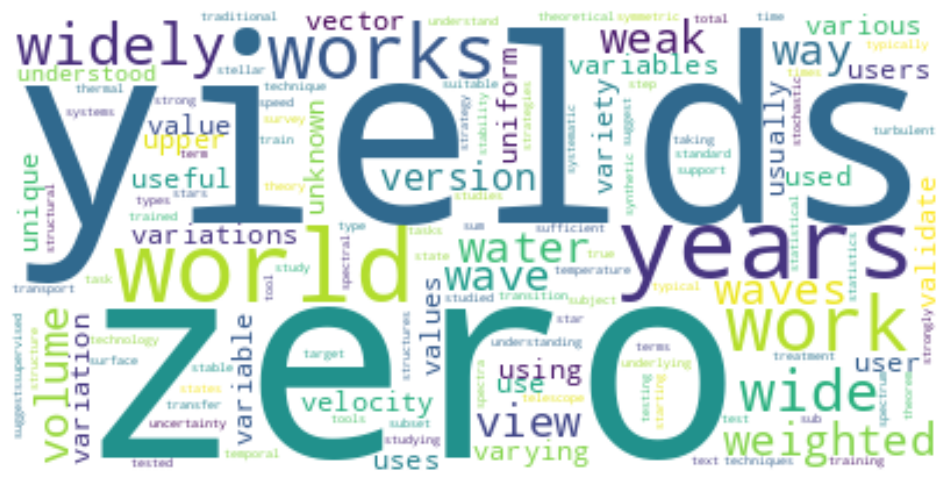

In [ ]:
wordcloud = WordCloud(background_color='white').generate_from_frequencies(cvec.vocabulary_)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off');

Since we have many dimensions (1000 features) we cannot do an exploratory analysis of the variables or a detailed visualization, so we will use **dimensionality reduction** to observe the **relationship between the features and the classes** (categories).

In [ ]:
# Initiating a PCA instance with 23 components
ncolumns = 23
pca = PCA(n_components= ncolumns)

In [ ]:
# Transform the data
pca.fit(X_train_v.toarray())

X_train_pca = pca.transform(X_train_v.toarray())
X_test_pca = pca.transform(X_test_v.toarray())

# Fit a KNNeighbor
Using the K-Nearest Neighbor using code from Udemy


In [ ]:
# Importing the KNN classifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Creating a KNN classifier
KNN = KNeighborsClassifier(n_neighbors=5)

In [ ]:
# Training the KNN models
KNN.fit(X_train_pca, y_train_l)

KNeighborsClassifier()

In [ ]:
# Setting the parameters
neighbors = {'n_neighbors': [1, 3, 7, 10]}

In [ ]:
# Fitting the model
grid_neighbor = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=neighbors, cv=5, verbose=2)
grid_neighbor.fit(X_train_pca, y_train_l)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ......................................n_neighbors=1; total time=   0.5s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.2s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.2s
[CV] END ......................................n_neighbors=3; total time=   0.2s
[CV] END ......................................n_neighbors=3; total time=   0.3s
[CV] END ......................................n_neighbors=3; total time=   0.2s
[CV] END ......................................n_neighbors=3; total time=   0.3s
[CV] END ......................................n_neighbors=3; total time=   0.1s
[CV] END ......................................n_neighbors=7; total time=   0.2s
[CV] END ......................................n_

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 7, 10]}, verbose=2)

In [ ]:
# Showing the results
pd.DataFrame(grid_neighbor.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002563,0.002109,0.222230,0.139075,1,{'n_neighbors': 1},0.667857,0.676786,0.687500,0.698214,0.701786,0.686429,0.012758,4
1,0.001589,0.000155,0.212745,0.066866,3,{'n_neighbors': 3},0.698214,0.703571,0.707143,0.710714,0.723214,0.708571,0.008406,3
2,0.003430,0.002827,0.161382,0.055713,7,{'n_neighbors': 7},0.742857,0.758929,0.764286,0.753571,0.717857,0.747500,0.016429,2
3,0.009716,0.006492,0.289135,0.115775,10,{'n_neighbors': 10},0.742857,0.766071,0.750000,0.758929,0.732143,0.750000,0.011899,1
